In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


In [3]:
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

In [46]:
def fun_radius_bbox(min_0, min_1, max_0, max_1):
    """
    radisu_bbox(min_0, min_1, max_0, max_1), correspond to the order of regionprops.bbox tuple
    """
    radius = 0.5 * ((max_1 - min_1)**2 + (max_0 - min_0)**2) ** 0.5
    return radius

def fun_crop_images(image, min_0, min_1, max_0, max_1, margin=0,im0max=10000,im1max=10000):
    min_0 = max(min_0-margin,0)
    max_0 = min(max_0+margin,im0max)
    min_1 = max(min_1-margin,0)
    max_1 = min(max_1+margin,im1max)
    crop_image = image[min_0:max_0, min_1:max_1].copy()
#     print((min_0, min_1, max_0, max_1))
    return crop_image

def fun_scan_range(cloc,radius,im1max=10000,im0max=10000,o_form='1D'):
    cloc = np.array(cloc);
    min_0 = int(max(np.round(cloc - radius)[0],0))
    min_1 = int(max(np.round(cloc - radius)[1],0))
    max_0 = int(min(np.round(cloc + radius)[0],im0max))
    max_1 = int(min(np.round(cloc + radius)[1],im1max))
    local_cloc = (int(cloc[0] - min_0), int(cloc[1] - min_1))
    if o_form == '1D':
        return (min_0, min_1, max_0, max_1), local_cloc
    elif o_form == '2D':
        return np.array([[min_0,min_1],[min_0,max_1],[max_0,max_1],[max_0,min_1]]), local_cloc

def fun_local_distance(blob_loc_tuple, local_cloc_tuple):
    r = ((blob_loc_tuple[0] - local_cloc_tuple[0]) ** 2 + ((blob_loc_tuple[1] - local_cloc_tuple[1]) ** 2) ) ** 0.5
    return r

def fun_similarity(oriIprops,nextIprops,distance_type='euclid'):
    similarity = [];
    num_blob = len(nextIprops);
    pi = 3.1415926
    for i in range(num_blob):
        if distance_type == 'euclid':
            difference = abs(oriIprops - nextIprops[i])/abs(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'area':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'eccentricity':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'moments_hu':
            difference = np.abs(np.abs(oriIprops) - np.abs(np.array(nextIprops[i],dtype=np.float)))/np.abs( np.max(np.abs(np.vstack((oriIprops,nextIprops[i]))),axis=0) + 10**(-16)) 
        
        elif distance_type == 'equivalent_diameter':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'orientation':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            similarity.append(np.cos(diff_angle))
            continue
        elif distance_type == 'angular':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            difference = np.cos(diff_angle) 
        similarity.append( 1 - difference) 
    return similarity

def fun_reconstruct_labeled_image(cell_global_coord,oriImL0, oriImL1, crop_range=None, op_clear_border=True,op_relabel=True):
    """ cell_global_coord = list of coordinate of the global index position of all the pixel in each blob
        oriImL1, oriImL0 = metadata_cache['image_shape][stack]
        crop_range = (min0, max0, min1, max1)
        return: labeled_image, blob_prop_List
    """
    cell_numbers = len(cell_global_coord);
    tempLabeledImage = np.zeros([oriImL0,oriImL1],dtype=np.int32)
    
    for tempBlobIndex in range(cell_numbers):
        tempBlobCoor = cell_global_coord[tempBlobIndex]
        tempLabeledImage[tempBlobCoor[:,0],tempBlobCoor[:,1]] = tempBlobIndex + 1
    if crop_range is not None:
        crop_0_min = crop_range[0]
        crop_0_max = crop_range[1]
        crop_1_min = crop_range[2]
        crop_1_max = crop_range[3]
        tempLabeledImage = tempLabeledImage[crop_0_min:crop_0_max, crop_1_min:crop_1_max]
    if op_clear_border:
        tempLabeledImage = skimage.segmentation.clear_border(tempLabeledImage)
        
    if op_relabel:
        im_label_ori = tempLabeledImage
        tempLabeledImage = skimage.measure.label(tempLabeledImage > 0)
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop, im_label_ori
    else:
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop

def fun_blobs_in_polygen(blob_centroid_list, contour_vertice_coor_array, crop_min_list=[0,0]):
    contourPath = matplotlib.path.Path(contour_vertice_coor_array[:,[1,0]] - crop_min_list) # Yuncong uses (row, col) while numpy use 
    return contourPath.contains_points(blob_centroid_list)

def fun_blobs_out_polygen(blob_centroid_list, contour_vertice_coor_array, crop_min_list=[0,0], margin=0):
    contour_polygon = Polygon(contour_vertice_coor_array[:,[1,0]] - crop_min_list)
    contour_polygon_with_margin = contour_polygon.buffer(margin, resolution=2)
    contour_polygon_with_margin = matplotlib.path.Path(list(contour_polygon_with_margin.exterior.coords))
    return np.logical_not(contour_polygon_with_margin.contains_points(blob_centroid_list))
    

In [ ]:
temp_PosSam_Polygon = Polygon(vertice_7N_dic[sec][:,[1,0]])
temp_surround = temp_PosSam_Polygon.buffer(margin,resolution=2)
tempPath_surr = matplotlib.path.Path(list(temp_surround.exterior.coords))
tempPath_surr.vertices

In [5]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 448
patch_half_size = patch_size / 2
stride = 112
# Crop images
# 
# crop_0_min = 9000
# crop_0_max = 10500
# crop_1_min = 3000
# crop_1_max = 4500

# Brain stem
crop_0_min = 7000
crop_0_max = 13000
crop_1_min = 3000
crop_1_max = 14000
# Inside
# crop_0_min = 4000
# crop_0_max = 6000
# crop_1_min = 2400
# crop_1_max = 4400

# Whole
# crop_0_min = 0
# crop_1_min = 0
# _, _, crop_1_max, crop_0_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
im0max = crop_0_max - crop_0_min
im1max = crop_1_max - crop_1_min

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

### Load and crop origninal images

In [6]:
# Set examine section number range and download from S3 if not available
section_begin = 152
section_end = 154
img_filename = {}
cell_centroids = {}
cell_numbers = {}
cell_global_coord = {}
secList = range(section_begin, section_end +1 )

for tempSec in secList:
    img_filename[tempSec] = DataManager.get_image_filepath(stack=stack, section=tempSec, resol='lossless', version='cropped')
    cell_centroids[tempSec] = load_cell_data('centroid',stack=stack,sec=tempSec)
    cell_numbers[tempSec] = cell_centroids[tempSec].shape[0]
    cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
    if os.path.isfile(img_filename[tempSec]):
        sys.stderr.write('Image file is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempSec])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            secList.remove(tempSec)
            continue           
            
    

Image file is already available. 
Image file is already available. 
Image file is already available. 


In [8]:
# Load image, change RGB images to grayscale image, rescale the grayscale
option_rescale_grayscale = True
option_inverse_color = False
sec = section_begin + 1

im_cropped = {}
im_rescale = {}
for tempSec in secList:
    im_cropped[tempSec] = img_as_ubyte(rgb2gray(imread(img_filename[tempSec])[crop_0_min:crop_0_max,crop_1_min:crop_1_max]))
    if option_rescale_grayscale:
        im_rescale[tempSec] = fun_rescale_grayscale_image(im_cropped[tempSec],invcol=option_inverse_color)
        del im_cropped[tempSec]


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


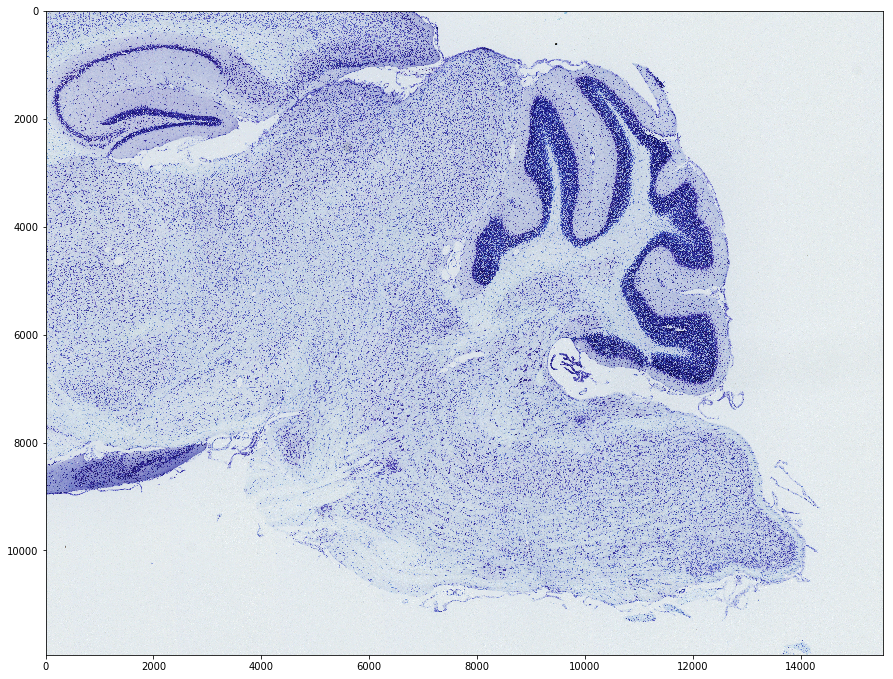

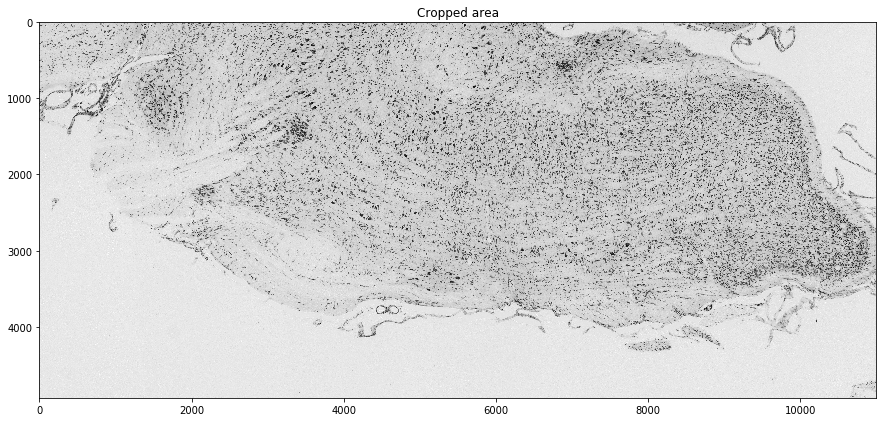

In [30]:
# # Show the entire image
# plt.figure(figsize=(15,15))
# plt.imshow(imread(img_filename[sec]))
# # Show the cropped image
# plt.figure(figsize=(15,15))
# plt.imshow(im_cropped[sec],cmap=plt.cm.gray)
# plt.title('Cropped area')
           

### Reconstruct labeled image from detected cell dataset

In [10]:
# Construct BW images
oriImL1,oriImL0 = metadata_cache['image_shape'][stack] # The order is annoying....

In [11]:
option_crop = True
option_clear_border = True
option_relabel = True
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
crop_range = (crop_0_min,crop_0_max,crop_1_min,crop_1_max)
for tempSec in secList:
    temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= crop_range, 
                                                                    oriImL0=oriImL0,oriImL1=oriImL1)
    im_label[tempSec] = temp_im_label
    im_BW[tempSec] = temp_im_label>0
    im_blob_prop[tempSec]  = np.array(temp_im_blob_prop)

n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}

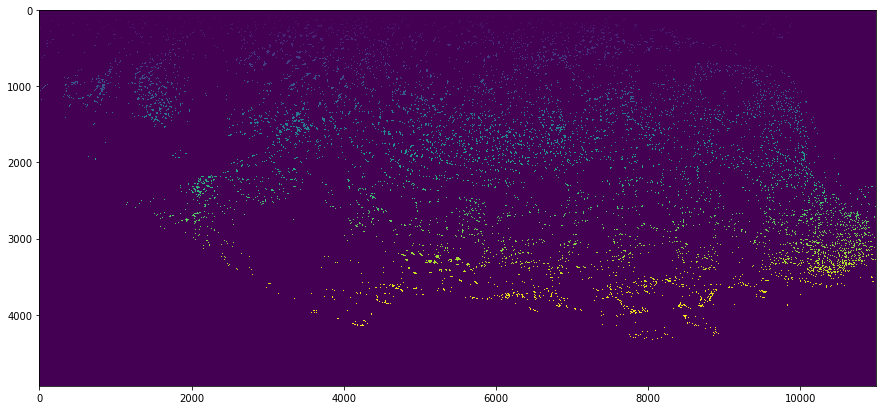

In [199]:
# plt.figure(figsize=(15,15))
# plt.imshow(im_label[sec])

To do list: 
1. Collect typical blobs. Typical in a sense that they match blobs in the corresponding neighboring region in the next section( based on the aligned image).
    - Read images of given sections in a given list as dictionary. Crop the brain stem area
    - Reconstruct labeled blob image
    - Write a function: input list of bolb centroid, vertice coordinate of the polygon, output the bool vector of existence
    - Check if each blob in section is typical or not. If yes, record the blob index, as well as the matched blob index in the nearby section: [sec, blobID, properties, scanSec, blobID, properties, similarity_vector]
    - Collect blobs in 10 consecutive sections, visualize the typical blob in 3D (?)
    

    

In [24]:
# Get positive example in 7N
contour, _ = DataManager.load_annotation_v3(stack=stack);
contour = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour,stack=stack)
structure_name = '7N'
vertice_7N_dic = {cnt['section']:cnt['vertices'] for _ , cnt in contour[contour['name'] == structure_name].iterrows()}

'No object named structures in the file'


Annotation has no structures.


In [65]:
temp_BIDInside_7N = {}
temp_BIDOutside_7N = {}
margin = 200
for sec in secList:
    temp_Blob_centroid = [im_blob_prop[sec][tempBID]['centroid'] for tempBID in range(n_blobs[sec])]
    temp_BlobInside_7N =  fun_blobs_in_polygen(temp_Blob_centroid, vertice_7N_dic[sec],crop_min_list=[crop_0_min,crop_1_min])
    temp_BlobOutside_7N = fun_blobs_out_polygen(temp_Blob_centroid, vertice_7N_dic[sec], crop_min_list=[crop_0_min, crop_1_min],margin=margin)
    
    temp_BIDInside_7N[sec] = np.where((temp_BlobInside_7N==True))[0]
    temp_BIDOutside_7N[sec] = np.where((temp_BlobOutside_7N==True))[0]

# Integrated - blob comparsion

In [69]:
# Parameters
scan_section_range = 1
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter'] # Features for comparison
prop_for_comparison = ['area', 'orientation','moments_hu']
typicalBlobs_dic = {}
matchedBlobs_dic = {}
compare_weight = [1 for i in range(len(prop_for_comparison) + 6)]
compare_weight = np.array(compare_weight)/ float(np.sum(compare_weight))
o_simil_threshold = 0.8
o_scan_size_coeff = 5
o_scan_size = 112
o_fix_scan_size = True

sec = section_begin + 1
scan_section = range(sec - scan_section_range, sec + scan_section_range + 1)
scan_section.remove(sec)

In [72]:
typical_blobs = []
matched_paris = []
# for blobID in range(n_blobs[sec]):
for blobID in temp_BIDInside_7N[sec]:
#     if (blobID % 1000) == 0:
#         print('Finished percentage: %f'%(float(blobID)*100 / n_blobs[sec]))
    temp_curr_blob_props = im_blob_prop[sec][blobID]
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    tempB1_orientation = temp_curr_blob_props['orientation']
    tempB1_hu = temp_curr_blob_props['moments_hu']
    tempB1_size = temp_curr_blob_props['area']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

    #################################
    for tempSec in scan_section:
        if tempSec not in secList:
#             print('Section %d is not in the load image list.'%tempSec);
            continue
        # Find blobs in the scaned section
        temp_im = fun_crop_images(im_label[tempSec],*temp_next_sec_range_1D, margin=0,im0max=im0max, im1max=im1max)
        tempBlobInsideIndex = np.delete(np.unique(temp_im.flatten()),0,axis=0) - 1 # Minus 1 because when reconstructing the labeled image, pixel for blob start at 1
        temp_num_blob = len(tempBlobInsideIndex)
        if temp_num_blob:
            temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            continue


        # Get blob properties
        temp_next_blob_props = {}
        for tempProp in prop:
            temp_prop_value = []
            for blobIndex in range(temp_num_blob):
                temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
            temp_next_blob_props[tempProp] = temp_prop_value
        temp_next_blob_props['relative_dict'] = []
        for blobIndex in range(temp_num_blob):
            temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))

        temp_sim = {}

        for temp_prop in prop_for_comparison:
                temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                         temp_next_blob_props[temp_prop],distance_type=temp_prop))
        temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

        # Blob comparison


        temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
        temp_compare_result = temp_weighted_sim > o_simil_threshold
        if any(temp_compare_result.tolist()):
            typical_blobs.append([sec, blobID, im_blob_prop[sec][blobID]])
            # list of [section, blobID, blob_properties, scan_section, matched_blob_IDs, matched_blobs_properties, match_blob_similarities]
            matched_paris.append([sec,blobID,im_blob_prop[sec][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])
typicalBlobs_dic[sec] = typical_blobs
matchedBlobs_dic[sec] = matched_paris

In [73]:
matched_paris

[[153,
  12738,
  154,
  array([13696]),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f66a4e3a790>], dtype=object),
  array([[ 0.05389908,  0.96580087,  0.99103262,  0.98937569,  0.94669811,
           0.97352482,  0.99611113,  0.99110402,  0.72807302]])],
 [153,
  13244,
  154,
  array([14698]),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f66a4d5a610>], dtype=object),
  array([[ 0.546875  ,  0.98969623,  0.9731521 ,  0.81656413,  0.89653523,
           0.88315986,  0.87384596,  0.80703107,  0.65912917]])],
 [153,
  13732,
  154,
  array([14870]),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f66a4d781d0>], dtype=object),
  array([[ 0.8       ,  0.91722193,  0.99358416,  0.66910344,  0.97340055,
           0.978111  ,  0.99196242,  0.82996986,  0.94305228]])],
 [153,
  13982,
  152,
  array([16634]),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f66b6dcfe10>], dtype=object),
  array([[ 0.

# Negative example

In [324]:
false_typicalBlobs_dic = {}
false_matchedBlobs_dic = {}

In [325]:
# Find compute similarity between blobs in 7N and blobs out of the annotated structure 7N, in the scaned section
false_typical_blobs = []
false_matched_paris = []
# for blobID in range(n_blobs[sec]):
for blobID in temp_BIDInside_7N[sec]:
#     if (blobID % 1000) == 0:
#         print('Finished percentage: %f'%(float(blobID)*100 / n_blobs[sec]))
    temp_curr_blob_props = im_blob_prop[sec][blobID]
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    tempB1_orientation = temp_curr_blob_props['orientation']
    tempB1_hu = temp_curr_blob_props['moments_hu']
    tempB1_size = temp_curr_blob_props['area']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

    #################################
    for tempSec in scan_section:
        if tempSec not in secList:
#             print('Section %d is not in the load image list.'%tempSec);
            continue
        tempBlobInsideIndex = temp_BIDOutside_7N[sec]
        temp_num_blob = len(tempBlobInsideIndex)
        if temp_num_blob:
            temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            continue


        # Get blob properties
        temp_next_blob_props = {}
        for tempProp in prop:
            temp_prop_value = []
            for blobIndex in range(temp_num_blob):
                temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
            temp_next_blob_props[tempProp] = temp_prop_value
        temp_next_blob_props['relative_dict'] = []
        for blobIndex in range(temp_num_blob):
            temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))

        temp_sim = {}

        for temp_prop in prop_for_comparison:
                temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                         temp_next_blob_props[temp_prop],distance_type=temp_prop))
        temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

        # Blob comparison


        temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
        temp_compare_result = temp_weighted_sim > o_simil_threshold
        if any(temp_compare_result.tolist()):
            false_typical_blobs.append([sec, blobID, im_blob_prop[sec][blobID]])
            # list of [section, blobID, blob_properties, scan_section, matched_blob_IDs, matched_blobs_properties, match_blob_similarities]
            false_matched_paris.append([sec,blobID,im_blob_prop[sec][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])
false_typicalBlobs_dic[sec] = false_typical_blobs
false_matchedBlobs_dic[sec] = false_matched_paris

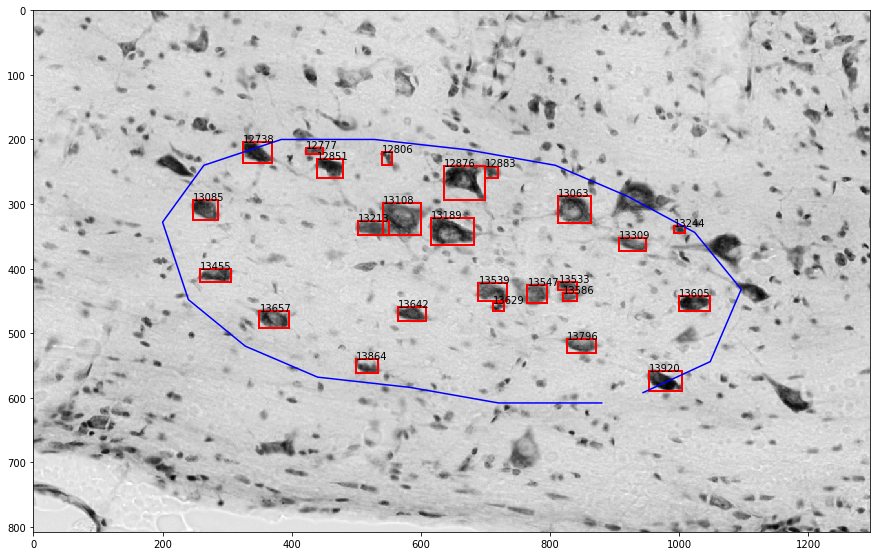

In [124]:
margin = 200
im_1_max,im_0_max = np.max(np.array(vertice_7N_dic[sec],dtype=np.int),axis=0) - np.array([crop_1_min, crop_0_min])
im_1_min,im_0_min = np.min(np.array(vertice_7N_dic[sec],dtype=np.int),axis=0) - np.array([crop_1_min, crop_0_min])

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(fun_crop_images(im_rescale[sec],im_0_min,im_1_min,im_0_max,im_1_max,im0max=im0max,im1max=im1max,margin=margin),cmap=plt.cm.gray)

for prop in im_blob_prop[sec][temp_BIDInside_7N[sec]]:
    if prop['area']>100:
        min0, min1, max0, max1 = prop['bbox'];
        rect = matplotlib.patches.Rectangle((min1-im_1_min + margin,min0-im_0_min + margin),max1-min1, max0-min0, fill=False,edgecolor='red',linewidth=2)
        ax.text(min1-im_1_min + margin, min0-im_0_min + margin, prop['label']-1)
        ax.add_patch(rect)
        
plt.plot(vertice_7N_dic[sec][:,0] - crop_1_min - im_1_min + margin,vertice_7N_dic[sec][:,1]-crop_0_min - im_0_min + margin,'-b')
plt.show()

In [240]:
typical_blob_in_sec153 = [13108, 13189, 12876, 13063]

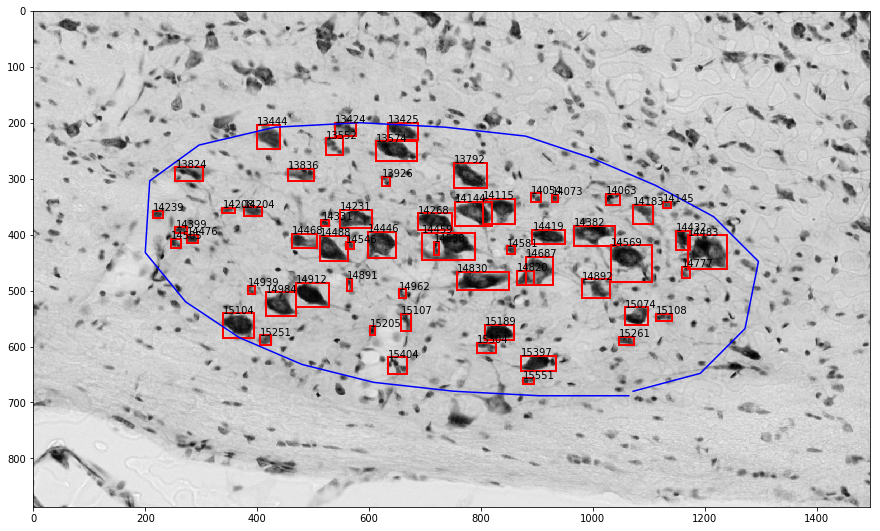

In [208]:
disp_sec = sec + 1
margin = 200
im_1_max,im_0_max = np.max(np.array(vertice_7N_dic[disp_sec],dtype=np.int),axis=0) - np.array([crop_1_min, crop_0_min])
im_1_min,im_0_min = np.min(np.array(vertice_7N_dic[disp_sec],dtype=np.int),axis=0) - np.array([crop_1_min, crop_0_min])

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(fun_crop_images(im_rescale[disp_sec],im_0_min,im_1_min,im_0_max,im_1_max,im0max=im0max,im1max=im1max,margin=margin),cmap=plt.cm.gray)

for prop in im_blob_prop[disp_sec][temp_BIDInside_7N[disp_sec]]:
    if prop['area']>100:
        min0, min1, max0, max1 = prop['bbox'];
        rect = matplotlib.patches.Rectangle((min1-im_1_min + margin,min0-im_0_min + margin),max1-min1, max0-min0, fill=False,edgecolor='red',linewidth=2)
        ax.text(min1-im_1_min + margin, min0-im_0_min + margin, prop['label']-1)
        ax.add_patch(rect)
        
plt.plot(vertice_7N_dic[disp_sec][:,0] - crop_1_min - im_1_min + margin,vertice_7N_dic[disp_sec][:,1]-crop_0_min - im_0_min + margin,'-b')
plt.show()

# Analyzing True-matched blobs
1. Cannot find much matched cells. Only 4 bolbs are classified as 'typical', and two(three) of the are small cells size = 128, 16, 25 
2. The cell-detection software detects much more blobs in section 152 and 154 than section 153. Looking from the image by naked eyes, it seems that the software neglected a lot of small blobs for unknown reasons. So the number of detected small blobs might be severely underestimated.
2. why the size histogram of the detected blobs seems so smooth? If there are different kind of cells in the brain, why we cannot see several peaks in the histogram?
3. What are the similarity between blobs that we think are 'typical'?

In [335]:
# index of the typical blobs and their sizes
[[matchedBlobs_dic[sec][tempIdx][2]['label']-1,matchedBlobs_dic[sec][tempIdx][2]['area']] for tempIdx in range(len(matchedBlobs_dic[sec]))]

[[12738, 872], [13244, 128], [13732, 16], [13982, 25]]

In [336]:
# Number of detected blobs
map(len,temp_BIDInside_7N.values())

[112, 57, 229]

In [337]:
# Compute the similarity between 'typical' blobs and all the other blobs in the region
temp_BIDInside_7N[sec]

array([12738, 12777, 12806, 12807, 12822, 12823, 12829, 12851, 12876,
       12882, 12883, 12906, 12932, 12955, 12967, 13005, 13063, 13075,
       13085, 13086, 13108, 13146, 13155, 13160, 13189, 13213, 13234,
       13244, 13255, 13294, 13309, 13360, 13455, 13533, 13539, 13547,
       13586, 13605, 13610, 13629, 13642, 13657, 13706, 13732, 13767,
       13788, 13792, 13796, 13864, 13882, 13920, 13939, 13964, 13982,
       13983, 13994, 13995])

In [338]:
test_typicalBlobs_dic = {}
test_matchedBlobs_dic = {}
test_infoRecord_dic = {}

In [339]:
# Find compute similarity between blobs in 7N and blobs out of the annotated structure 7N, in the scaned section
test_typical_blobs = []
test_matched_paris = []
test_infoRecord = []
# for blobID in range(n_blobs[sec]):
for blobID in temp_BIDInside_7N[sec]:
#     if (blobID % 1000) == 0:
#         print('Finished percentage: %f'%(float(blobID)*100 / n_blobs[sec]))
    temp_curr_blob_props = im_blob_prop[sec][blobID]
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    tempB1_orientation = temp_curr_blob_props['orientation']
    tempB1_hu = temp_curr_blob_props['moments_hu']
    tempB1_size = temp_curr_blob_props['area']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

    #################################
    for tempSec in scan_section:
        if tempSec not in secList:
#             print('Section %d is not in the load image list.'%tempSec);
            continue
        tempBlobInsideIndex = temp_BIDInside_7N[tempSec]
        temp_num_blob = len(tempBlobInsideIndex)
        if temp_num_blob:
            temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            continue


        # Get blob properties
        temp_next_blob_props = {}
        for tempProp in prop:
            temp_prop_value = []
            for blobIndex in range(temp_num_blob):
                temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
            temp_next_blob_props[tempProp] = temp_prop_value
        temp_next_blob_props['relative_dict'] = []
        for blobIndex in range(temp_num_blob):
            temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))

        temp_sim = {}

        for temp_prop in prop_for_comparison:
                temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                         temp_next_blob_props[temp_prop],distance_type=temp_prop))
        temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

        # Blob comparison


        temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
        temp_compare_result = temp_weighted_sim > o_simil_threshold
        test_infoRecord.append([sec, blobID, tempBlobInsideIndex, temp_weighted_sim, temp_sim_matrix])
        if any(temp_compare_result.tolist()):
            test_typical_blobs.append([sec, blobID, im_blob_prop[sec][blobID]])
            # list of [section, blobID, blob_properties, scan_section, matched_blob_IDs, matched_blobs_properties, match_blob_similarities]
            test_matched_paris.append([sec,blobID,im_blob_prop[sec][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])
test_typicalBlobs_dic[sec] = test_typical_blobs
test_matchedBlobs_dic[sec] = test_matched_paris
test_infoRecord_dic[sec] = test_infoRecord

In [340]:
typical_blob_in_sec153

[13108, 13189, 12876, 13063]

In [341]:
np.where(np.array([record[1] for record in test_infoRecord_dic[sec]])==13108)

(array([40, 41]),)

In [342]:
prop_for_comparison

['area', 'orientation', 'moments_hu']

array([ 0.73249086,  0.7237516 ,  0.69287171,  0.67959415,  0.67793142,
        0.67656787,  0.66985992,  0.6326244 ,  0.61848311,  0.59468074,
        0.58849679,  0.58836328,  0.58463042,  0.58242597,  0.58110164,
        0.57709466,  0.57541022,  0.57410176,  0.56661533,  0.56419884,
        0.56237554,  0.55543546,  0.55413002,  0.55341292,  0.5495018 ,
        0.54773058,  0.54729824,  0.5356503 ,  0.53291483,  0.53257978,
        0.53197148,  0.53029091,  0.52486029,  0.52455048,  0.52056382,
        0.51867743,  0.51318493,  0.51299273,  0.51289166,  0.51174765,
        0.50877164,  0.50848911,  0.49384614,  0.48936752,  0.48611619,
        0.48459497,  0.48226011,  0.48100392,  0.47967181,  0.47877713,
        0.47502043,  0.47489018,  0.47128629,  0.46974841,  0.45824866,
        0.45534864,  0.45345205,  0.45087994,  0.45045287,  0.44876974,
        0.44876039,  0.44376032,  0.44157089,  0.4409412 ,  0.43713058,
        0.43415775,  0.4318289 ,  0.43093441,  0.42790927,  0.42

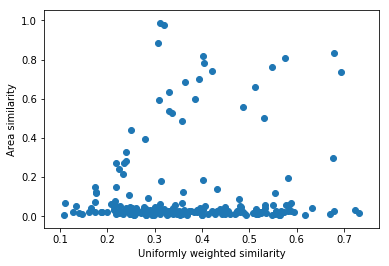

In [343]:
record_index = 41
plt.scatter(test_infoRecord_dic[sec][record_index][3], test_infoRecord_dic[sec][record_index][4][:,0])
plt.xlabel('Uniformly weighted similarity')
plt.ylabel('Area similarity')


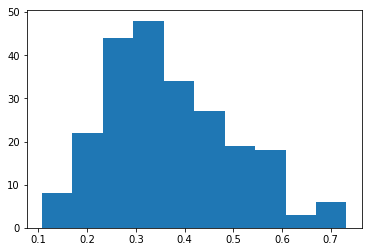

In [344]:
plt.hist(test_infoRecord_dic[sec][record_index][3]);

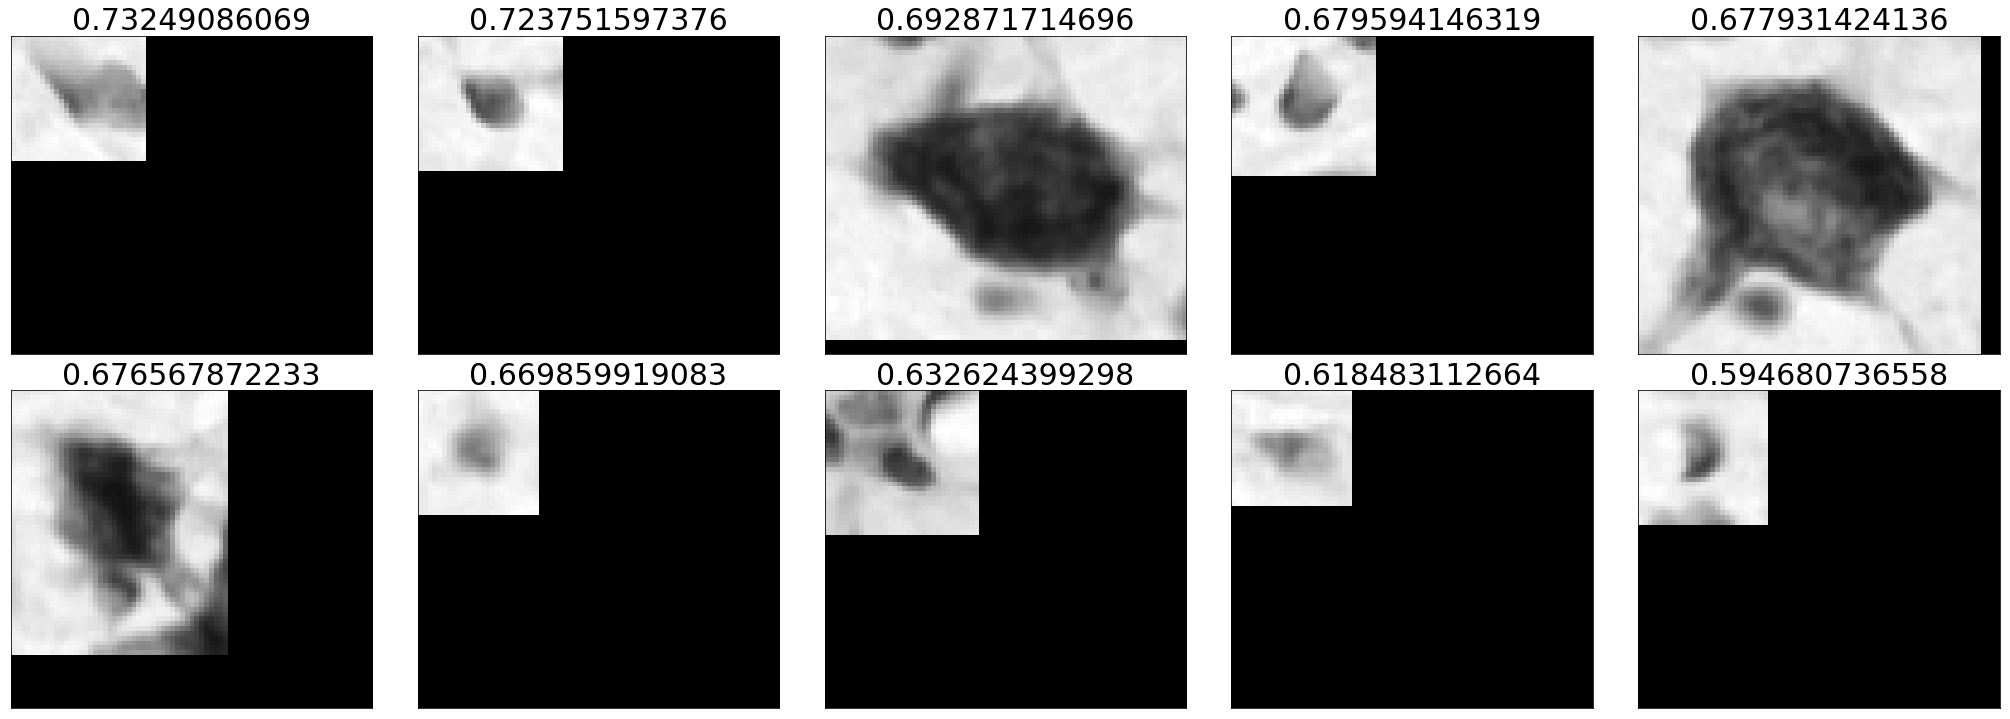

In [358]:
# Sort the compared blobID according to the overall similarity
disp_margin = 10
temp_sorted_idx = test_infoRecord_dic[sec][record_index][3].argsort()[::-1]
temp_sorted_BID = test_infoRecord_dic[sec][record_index][2][temp_sorted_idx]
temp_sorted_overall_simi = test_infoRecord_dic[sec][record_index][3][temp_sorted_idx]
display_images_in_grids([fun_crop_images(im_rescale[154], *im_blob_prop[154][tempBID]['bbox'], margin=disp_margin, im0max=im0max, im1max=im1max) for tempBID in temp_sorted_BID[0:10]],titles=temp_sorted_overall_simi[0:10],nc=5,
                        cmap=plt.cm.gray)
# test_infoRecord_dic[sec][record_index][2][temp_sorted_idxh

In [225]:
# Even when looking at all the blobs in the annotated region, the current algorithm cannot find the large cells 
# that we think are typical in 7N. Is our intuition wrong? 
[[record[1], record[2]['area']] for record in test_typicalBlobs_dic[sec]]

[[12738, 872],
 [12851, 714],
 [12882, 14],
 [12882, 14],
 [13086, 28],
 [13244, 128],
 [13586, 157],
 [13629, 110],
 [13629, 110],
 [13706, 18],
 [13732, 16],
 [13788, 11]]

# Analyzing False-matched blobs
1. Small blobs can find much more similar blobs in the other region than large blobs. 


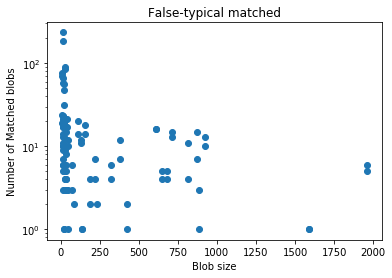

In [326]:
temp_size_vs_matched = np.array([[record[2]['area'], len(record[4])] for record in false_matchedBlobs_dic[sec]])
plt.scatter(temp_size_vs_matched[:,0],temp_size_vs_matched[:,1],)
plt.yscale('log')
plt.xlabel('Blob size')
plt.ylabel('Number of Matched blobs')
plt.title('False-typical matched')

In [327]:
temp_idx_size_num = np.array([[record[2]['label']-1,record[2]['area'], len(record[4])] for record in false_matchedBlobs_dic[sec]])
temp_idx_size_num[temp_idx_size_num[:,1].argsort()]

array([[13155,    11,    19],
       [13155,    11,    24],
       [13788,    11,    70],
       [13788,    11,    77],
       [13610,    13,     6],
       [13234,    13,     6],
       [13234,    13,     5],
       [13610,    13,     3],
       [13994,    14,    17],
       [13994,    14,    21],
       [12882,    14,   235],
       [12882,    14,   184],
       [13983,    16,    10],
       [13939,    16,    14],
       [13939,    16,    10],
       [13983,    16,     9],
       [13732,    16,    66],
       [13732,    16,    57],
       [12807,    17,    20],
       [13005,    17,    13],
       [13005,    17,    17],
       [12807,    17,    18],
       [13706,    18,    23],
       [13706,    18,    23],
       [13255,    19,     7],
       [13255,    19,    11],
       [13882,    21,    13],
       [12932,    21,     5],
       [12932,    21,     6],
       [13882,    21,    20],
       [13995,    23,    48],
       [13995,    23,    56],
       [13982,    25,    31],
       [13

### Example: 2 outside blobs matched with 7N 'typical' blob 13189. 
1. One matched due to not optimized weight (matched in terms of shape, but its size is totally off)
2. Another looks really similar, but their size are quite different 1588 vs. 333. In biology, are they really the same kind of cells? 

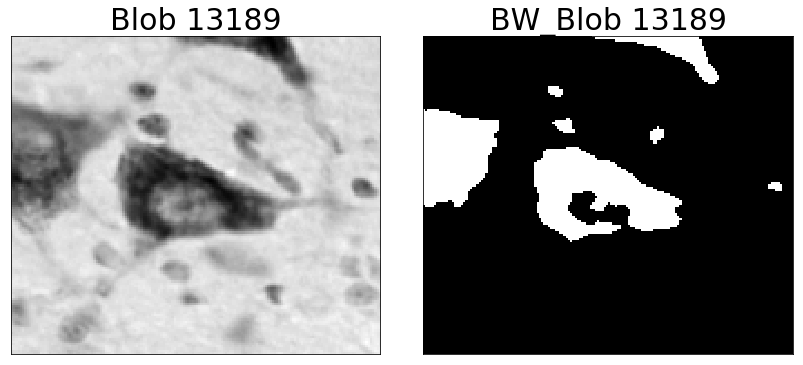

In [328]:
disp_sec = sec
disp_margin = 50
disp_blobID = 13189
display_images_in_grids([fun_crop_images(im_rescale[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max),
                        fun_crop_images(im_BW[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max)]
                        ,titles=['Blob %d'%disp_blobID,'BW_Blob %d'%disp_blobID]
                        ,
                        nc=2,cmap=plt.cm.gray)

In [329]:
np.where(np.array([record[1] for record in false_matchedBlobs_dic[sec] ]) == 13189)

(array([41, 42]),)

In [330]:
false_matchedBlobs_dic[sec][41]

[153,
 13189,
 152,
 array([9397]),
 array([<skimage.measure._regionprops._RegionProperties object at 0x7f66b725b050>], dtype=object),
 array([[ 0.01448363,  0.9952961 ,  0.98291133,  0.61975734,  0.889208  ,
          0.98030223,  0.89258691,  0.89162499,  0.96040553]])]

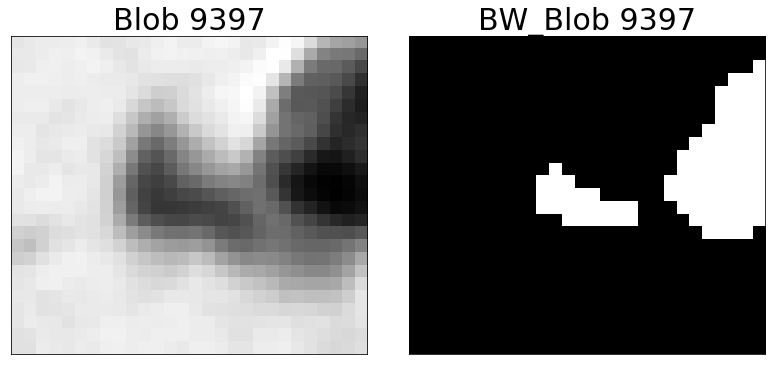

In [331]:
disp_sec = 152
disp_margin = 10
disp_blobID = 9397
display_images_in_grids([fun_crop_images(im_rescale[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max),
                        fun_crop_images(im_BW[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max)]
                        ,titles=['Blob %d'%disp_blobID,'BW_Blob %d'%disp_blobID]
                        ,
                        nc=2,cmap=plt.cm.gray)

In [178]:
false_matchedBlobs_dic[sec][42]

[153,
 13189,
 154,
 array([422]),
 array([<skimage.measure._regionprops._RegionProperties object at 0x7f66b596cc50>], dtype=object),
 array([[ 0.20969773,  0.9640044 ,  0.98665966,  0.75474005,  0.93916275,
          0.98211956,  0.945429  ,  0.71390645,  0.79065136]])]

In [332]:
false_matchedBlobs_dic[sec][42][5][0]['area']

333

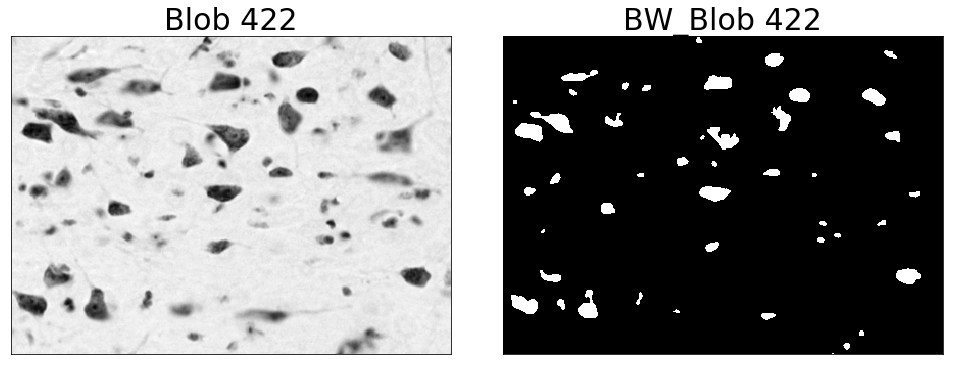

In [333]:
disp_sec = 154
disp_margin = 200
disp_blobID = 422
display_images_in_grids([fun_crop_images(im_rescale[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max),
                        fun_crop_images(im_BW[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max)]
                        ,titles=['Blob %d'%disp_blobID,'BW_Blob %d'%disp_blobID]
                        ,
                        nc=2,cmap=plt.cm.gray)

In [190]:
# Where the outside matched blob is?
im_blob_prop[154][422]['centroid']

(100.63663663663664, 669.44444444444446)

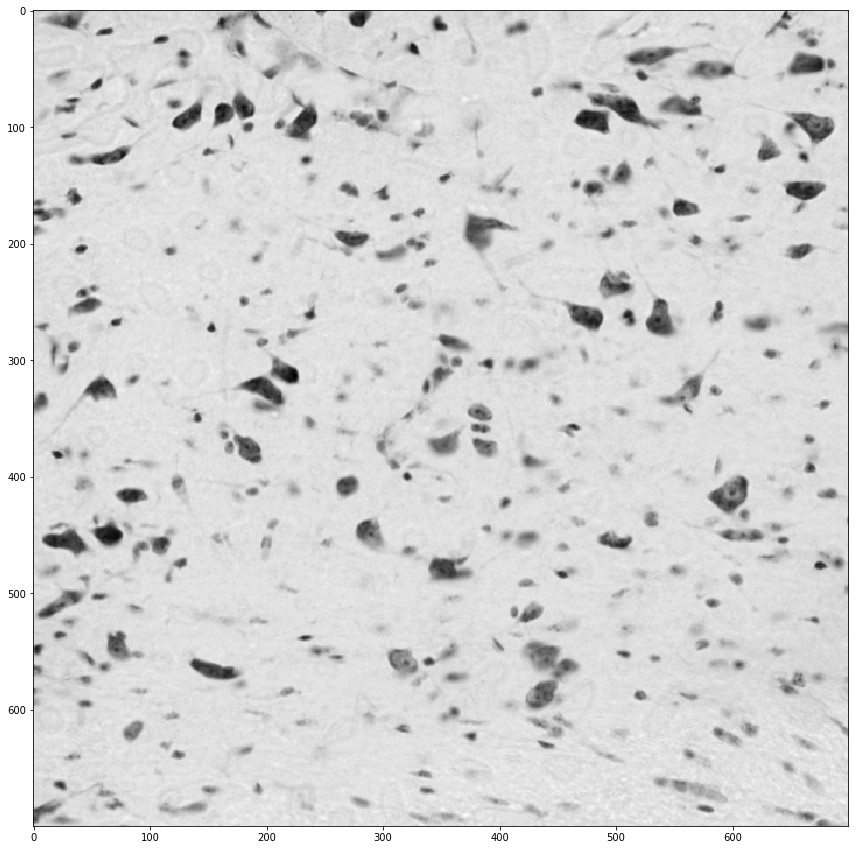

In [189]:
plt.figure(figsize=(15,15))
plt.imshow(fun_crop_images(im_rescale[154],0,0,700,700),cmap=plt.cm.gray)